### After running MRDICE script how do matched clusters gene dstributions vary?

In [41]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

### Use Sample AnnData object to get gene distributio

In [ ]:
folder = Path("assets/test_data/MISC3_151674/")
sample = ad.read_h5ad(folder / "MISC3.h5")

sample


AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', '151674_deepst_7_clusters.csv', '151674_deepst_6_clusters.csv', '151674_deepst_3_clusters.csv', '151674_deepst_4_clusters.csv', '151674_deepst_9_clusters.csv', '151674_deepst_5_clusters.csv', '151674_deepst_8_clusters.csv', '151674_deepst_2_clusters.csv'
    var: 'gene_ids', 'feature_types', 'genome', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'moranI', 'spatial', 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

### Use Region Mapping to find which domains to compare

In [ ]:
region_mapping = pd.read_csv(
    folder / "mrdice" / "151674_MISC3_clgraph_2_cluster_vs_151674_MISC3_clgraph_8_cluster.csv"
)
region_mapping.head()

,s2,s1,dice,method1,method2
0,0,0,0.994607,151674_deepst_8_cluster,151674_deepst_9_cluster
1,1,1,0.986714,151674_deepst_8_cluster,151674_deepst_9_cluster
2,2,2,0.985696,151674_deepst_8_cluster,151674_deepst_9_cluster
3,4,3,0.862479,151674_deepst_8_cluster,151674_deepst_9_cluster
4,6,4,0.998805,151674_deepst_8_cluster,151674_deepst_9_cluster


In [44]:
def get_cols(columns,keys):
    for col in columns:
        for key in keys:
            if key in col:
                yield col

### Get the SDI columns labels

In [45]:
m1,m2 = region_mapping.loc[0,['method1','method2']]
m1,m2 = list(get_cols(sample.obs.columns,[m1,m2]))
m1,m2

('151674_deepst_9_clusters.csv', '151674_deepst_8_clusters.csv')

In [46]:
c1, c2 = region_mapping.loc[1,['s1','s2']]
c1,c2

(np.int64(1), np.int64(1))

### Create mask of  spatially varying genes

In [47]:
from sdi_variation.downstream import get_panel,index_genes,plot_gene_dist,cluster_mask

_,goi,panel_size = get_panel(sample,t = 0.3)
panel_size

np.int64(330)

In [48]:
def get_clust(sample,c1,c2):
    m1_clust = cluster_mask(sample.obs[m1],c1)
    m2_clust = cluster_mask(sample.obs[m2],c2)
    return m1_clust,m2_clust

### Plot Gene Distribution for specific Domain
* First plot with the optimal matched domain
* then plot with a random domain to compare

In [49]:
from sdi_variation.downstream import bhattacharyya_distance

Text(0.5, 1.0, 'Cluster 1 Cluster 1 Gene Distribution (Optimal BD=0.0105)')

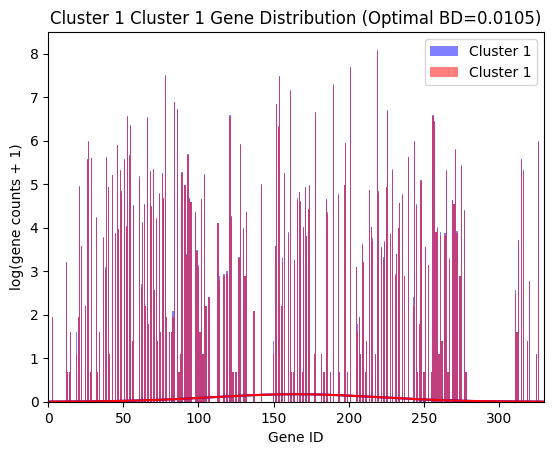

In [50]:
m1_clust,m2_clust = get_clust(sample,c1,c2)
m1_dist = index_genes(
    sample.X.toarray(),
    row_indexer=m1_clust,
    col_indexer=goi
).sum(axis=0)
m2_dist = index_genes(
    sample.X.toarray(),
    row_indexer=m2_clust,
    col_indexer=goi
).sum(axis=0)
d = bhattacharyya_distance(m1_dist,m2_dist)
ax = plt.figure().add_subplot()
plot_gene_dist(
    m1_dist,
    panel_size=panel_size,
    colour=(0,0,1),
    label=f"Cluster {c1}",
    ax = ax
)
plot_gene_dist(
    m2_dist,
    panel_size=panel_size,
    colour=(1,0,0),
    label=f"Cluster {c2}",
    ax = ax
)
plt.legend()
plt.title(f"Cluster {c1} Cluster {c2} Gene Distribution (Optimal BD={d:.4f})")

Text(0.5, 1.0, 'Cluster 1 Cluster 2 Gene Distribution (Random BD=0.5282)')

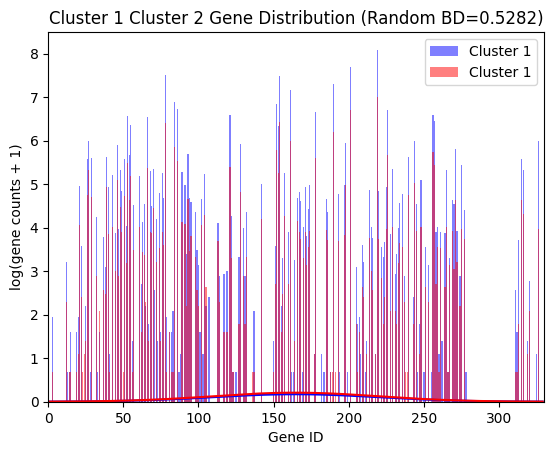

In [51]:
other = np.random.choice(region_mapping['s2'])
while other == c2: other = np.random.choice(region_mapping['s2'])
m1_clust,m2_clust = get_clust(sample,c1,other)
m1_dist = index_genes(
    sample.X.toarray(),
    row_indexer=m1_clust,
    col_indexer=goi
).sum(axis=0)
m2_dist = index_genes(
    sample.X.toarray(),
    row_indexer=m2_clust,
    col_indexer=goi
).sum(axis=0)
d = bhattacharyya_distance(m1_dist,m2_dist)

ax = plt.figure().add_subplot()
plot_gene_dist(
    m1_dist,
    panel_size=panel_size,
    colour=(0,0,1),
    label=f"Cluster {c1}",
    ax = ax
)
plot_gene_dist(
    m2_dist,
    panel_size=panel_size,
    colour=(1,0,0),
    label=f"Cluster {c2}",
    ax = ax
)
plt.legend()
plt.title(f"Cluster {c1} Cluster {other} Gene Distribution (Random BD={d:.4f})")

## For all matched domains compare gene counts
we will compare gene counts across domains matched by MRDice.  We will return the L1 distance between counts since bhattacharyya distance does not handle 0 counts well

In [53]:
under_col = region_mapping[['s1','s2']].max(axis = 0).idxmin()
over_col = region_mapping[['s1','s2']].max(axis = 0).idxmax()
s2m = {'s1':m1,'s2':m2}

In [54]:
r1 = region_mapping[under_col].unique()[0]
r1

np.int64(0)

In [55]:
merged = region_mapping.loc[region_mapping[under_col] == r1, over_col]
merged

0    0
Name: s2, dtype: int64

In [56]:
from sdi_variation.downstream import merged_c_masks,index_genes,get_panel
n_rs = np.zeros(
    shape=(
        region_mapping[under_col].unique().size,
        region_mapping[under_col].unique().size
    )
)



Text(0.5, 0, 'Region Pairs')

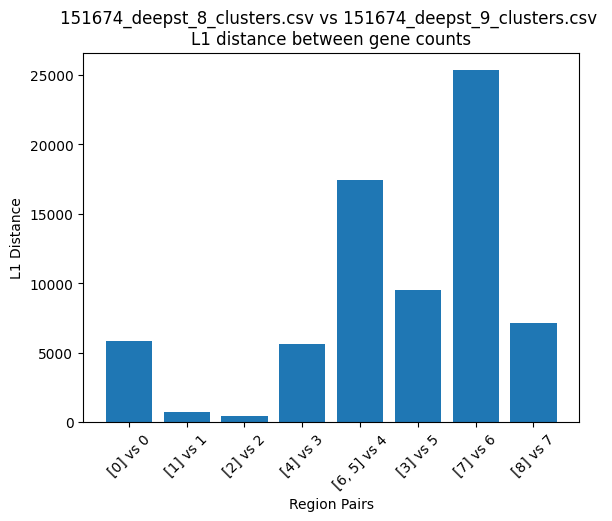

In [64]:
optimal_loss = {} 
scores = {}
for i in region_mapping[under_col].unique():
    merged = region_mapping.loc[region_mapping[under_col] == i, over_col]
    score = region_mapping.loc[region_mapping[under_col] == i, 'dice'].mean()
    sr1_genes = merged_c_masks(
        sample.obs[s2m[under_col]],
        region_mapping.loc[merged,over_col].values.tolist()
    )
    sr2_genes = merged_c_masks(
        sample.obs[s2m[over_col]],
        [region_mapping.loc[i,under_col]]
    )
    gene_counts = sample.X.toarray()
    sr1_counts = index_genes(gene_counts,sr1_genes,goi).sum(axis=0)
    sr2_counts = index_genes(gene_counts,sr2_genes,goi).sum(axis = 0)
    optimal_loss[f"{merged.values.tolist()} vs {i}"] = np.abs(sr1_counts - sr2_counts).sum()
    scores[f"{merged.values.tolist()} vs {i}"] = score
plt.bar(range(len(optimal_loss)),list(optimal_loss.values()))
plt.xticks(range(len(optimal_loss)),labels=list(optimal_loss.keys()),rotation = 45)
plt.title(f"{s2m[over_col]} vs {s2m[under_col]} \nL1 distance between gene counts")
plt.ylabel("L1 Distance")
plt.xlabel("Region Pairs")

Text(0, 0.5, 'L1 Gene Distance')

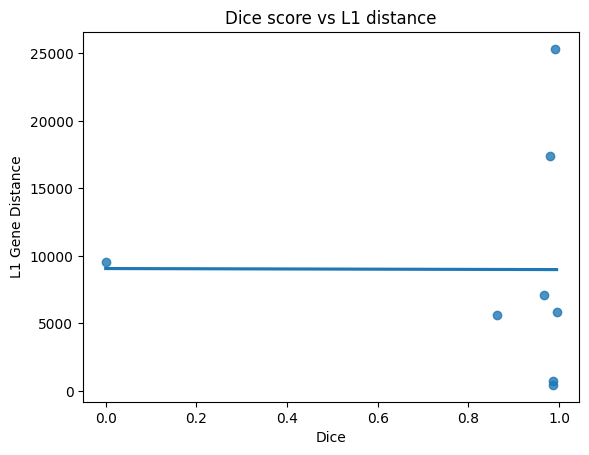

In [79]:
import seaborn as sns
x = np.array(list(scores.values()))
y = np.array(list(optimal_loss.values()))
inliers = x  > -1




sns.regplot(x = x[inliers],y = y[inliers], ci= None)
plt.title("Dice score vs L1 distance")
plt.xlabel("Dice")
plt.ylabel("L1 Gene Distance")

### What do similar gene distributions look like as domains in the segmentation mask

In [ ]:
deepst9 = folder / "masks" / "151674_clgraph_2_cluster_.tif"
deepst8 = folder / "masks" / "151674_clgraph_8_cluster_.tif"

In [59]:
s1 = plt.imread(deepst9)[:,:,0].squeeze()
s2 = plt.imread(deepst8)[:,:,0].squeeze()

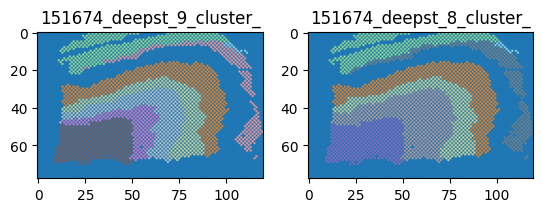

In [60]:
plt.subplot(1,2,1)
plt.title(deepst9.stem)
plt.imshow(s1,cmap='tab20')
plt.subplot(1,2,2)
plt.title(deepst8.stem)
plt.imshow(s2,cmap='tab20')

0.9856957087126138


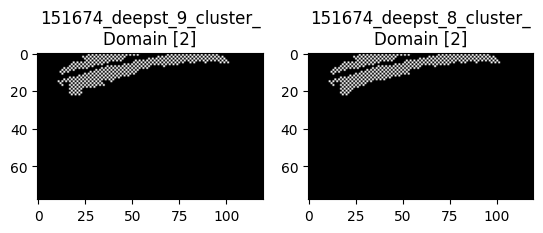

In [61]:
from scipy.spatial.distance import dice
r1 = [2]
r2 = [2]
mask1 = np.zeros(shape=s1.shape)
mask2 = np.zeros(shape=s2.shape)

for r in r1:
    mask1[s1 == r] = 1

for r in r2:
    mask2[s2 == r] = 1

plt.subplot(1,2,1)
plt.title(deepst9.stem + f"\nDomain {r1}")
plt.imshow(mask1,cmap='gray')
plt.subplot(1,2,2)
plt.title(deepst8.stem + f"\nDomain {r2}")
plt.imshow(mask2,cmap='gray')
print(1-dice(mask1.flatten(),mask2.flatten()))